C:\Users\jagad\AppData\Local\Temp\ipykernel_4468\3420688322.py:12: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\UNSW-NB15_1.csv', names=headers)


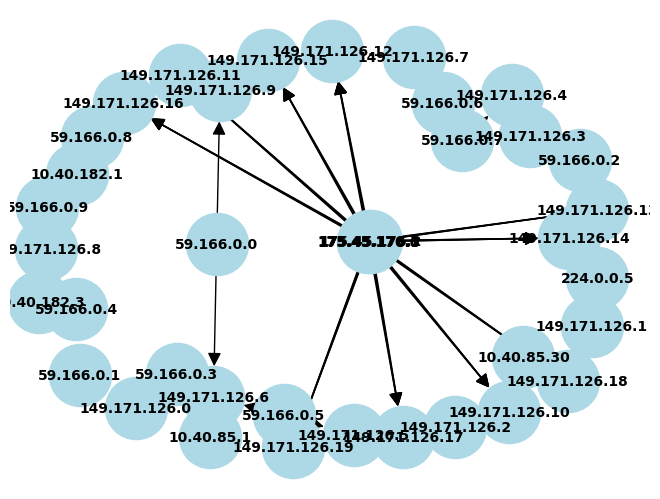

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import StandardScaler


# Load your dataset
df = pd.read_csv(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\combined_data.csv')

# Drop specified columns
columns_to_drop = ['dsport', 'sloss', 'dloss', 'Sintpkt', 'Dintpkt', 'Stime', 'Ltime', 'attack_cat']
df = df.drop(columns=columns_to_drop)

# Convert column names to lowercase
df.columns = df.columns.str.lower()

sample_df = df.head(6000)

# Create a directed graph
G = nx.DiGraph()
count = 0
countatt = 0
# Iterate through the sample and add nodes and edges to the graph
for index, row in sample_df.iterrows():
    src_ip = row['srcip']
    dst_ip = row['dstip']
    if src_ip == dst_ip:
        continue
    # Add nodes
    G.add_node(src_ip)
    G.add_node(dst_ip)
    if row['label'] == 1:
        countatt = 1
        edge_attributes = row.drop(['srcip', 'dstip']).to_dict()
        G.add_edge(src_ip, dst_ip, **edge_attributes)
    else:
        if count < 9:
    # Add directed edge with specified attributes
            edge_attributes = row.drop(['srcip', 'dstip']).to_dict()
            G.add_edge(src_ip, dst_ip, **edge_attributes)
            count += 1
    if count >= 10:
        break
        
    

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, font_color='black', node_color='lightblue', font_weight='bold', arrowsize=20)
plt.show()





In [3]:
import os

# Specify the path for the output GEXF file in the Downloads folder
output_file_path = os.path.join(os.path.expanduser('~'), r'C:\Users\jagad\Downloads', 'graph_output.gexf')


# Write the graph to a GEXF file
nx.write_gexf(G, output_file_path)

print(f"Graph has been written to {output_file_path}")


Graph has been written to C:\Users\jagad\Downloads\graph_output.gexf


In [7]:
from neo4j import GraphDatabase

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")

with GraphDatabase.driver(URI, auth=AUTH) as driver: 
    driver.verify_connectivity()

In [2]:
import csv
from neo4j import GraphDatabase

# Assuming you have a Neo4j server running locally
uri = "bolt://localhost:7687"
username = "neo4j"
password = "password"

def create_node(tx, ip_address):
    query = (
        "MERGE (n:IP {ip_address: $ip_address})"
    )
    tx.run(query, ip_address=ip_address)

# Read nodes from CSV file
nodes = []
with open(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\combined_data.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Assuming 'srcip' is the column containing IP addresses
        nodes.append({'ip_address': row['srcip']})

# List of edges (replace with your actual data)
edges = [
    {'src_ip': '192.168.1.1', 'dst_ip': '192.168.1.2', 'label': 'some_label', 'proto': 'TCP', 'state': 'ESTABLISHED', 'dur': 10, 'spkts': 100, 'dpkts': 50}
]

# Create a Neo4j session
with GraphDatabase.driver(uri, auth=(username, password)) as driver:
    with driver.session() as session:
        # Create nodes
        for node in nodes:
            session.write_transaction(create_node, node['ip_address'])

        # Create relationships
        with driver.session() as session:
            for edge in edges:
                session.run("""
                    MATCH (src:IP {ip_address: $src_ip}), (dst:IP {ip_address: $dst_ip})
                    MERGE (src)-[:COMMUNICATES_WITH {label: $label, proto: $proto, state: $state, dur: $dur, spkts: $spkts, dpkts: $dpkts}]->(dst)
                """, src_ip=edge['src_ip'], dst_ip=edge['dst_ip'], label=edge['label'], proto=edge['proto'], state=edge['state'], dur=edge['dur'],
                spkts=edge['spkts'], dpkts=edge['dpkts'])


C:\Users\jagad\AppData\Local\Temp\ipykernel_4496\2010795508.py:33: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_node, node['ip_address'])


KeyboardInterrupt: 

In [19]:
from neo4j import GraphDatabase
import csv

# Assuming you have a Neo4j server running locally
uri = "bolt://localhost:7687"
username = "neo4j"
password = "password"

def create_edge(tx, edge):
    query = (
        """
        MATCH (src:IP {ip_address: $src_ip}), (dst:IP {ip_address: $dst_ip})
        MERGE (src)-[:COMMUNICATES_WITH {label: $label, proto: $proto, state: $state, dur: $dur, spkts: $spkts, dpkts: $dpkts}]->(dst)
        """
    )
    tx.run(query, src_ip=edge['src_ip'], dst_ip=edge['dst_ip'], label=edge['some_label'], proto=edge['proto'], state=edge['state'], dur=edge['dur'], spkts=edge['spkts'], dpkts=edge['dpkts'])


# Read nodes from CSV file
nodes = []
with open(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\combined_data.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Assuming 'srcip' and 'dstip' are the columns containing IP addresses
        nodes.append({'src_ip': row['srcip'], 'dst_ip': row['dstip']})

# Create a Neo4j session
with GraphDatabase.driver(uri, auth=(username, password)) as driver:
    with driver.session() as session:
        # Create relationships
        for edge in nodes:
            session.write_transaction(create_edge, edge)


C:\Users\jagad\AppData\Local\Temp\ipykernel_10064\4104445661.py:32: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_edge, edge)


KeyError: 'some_label'

In [3]:
df.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload',
       'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime',
       'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'Label'],
      dtype='object')